# Correlation matrices visualization of CIFAR-100 models

In [7]:
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn
import sys, os
sys.path.append(os.path.join(os.getcwd(),'../..'))
print(os.getcwd())

from mdistiller.models import cifar_model_dict
from mdistiller.dataset import get_dataset
from mdistiller.engine.utils import load_checkpoint
from mdistiller.engine.cfg import CFG as cfg

/home/ssq/Desktop/phd/KD/logit-standardization-KD/tools/visualizations


In [8]:
# visualize the difference between the teacher's output logits and the student's
def normalize(logit):
    mean = logit.mean(dim=-1, keepdims=True)
    stdv = logit.std(dim=-1, keepdims=True)
    return (logit - mean) / stdv

def get_output_metric(model, val_loader, num_classes=100, ifstand=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            outputs, _ = model(data)
            if ifstand:
                preds = normalize(outputs)
            else:
                preds = outputs
            all_preds.append(preds.data.cpu().numpy())
            all_labels.append(labels.data.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, 0)
    all_labels = np.concatenate(all_labels, 0)
    matrix = np.zeros((num_classes, num_classes))
    cnt = np.zeros((num_classes, 1))
    for p, l in zip(all_preds, all_labels):
        cnt[l, 0] += 1
        matrix[l] += p
    matrix /= cnt
    return matrix

def get_tea_stu_diff(tea, stu, mpath, max_diff, ifstand=False):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    model.load_state_dict(load_checkpoint(mpath)["model"])
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    print("load model successfully!")
    ms = get_output_metric(model, val_loader, ifstand=ifstand)
    mt = get_output_metric(tea_model, val_loader, ifstand=ifstand)
    diff = np.abs((ms - mt))
    for i in range(100):
        diff[i, i] = 0
    print('max(diff):', diff.max(), diff.argmax())
    print('mean(diff):', diff.mean())
#     diff[diff>0.1] /= 10
    seaborn.heatmap(diff, vmin=0, vmax=max_diff, cmap="Reds", cbar_kws = dict(use_gridspec=False,location="left"))
#     plt.tight_layout()
    plt.show()
    return diff

In [8]:
# set a common max-value of the difference for fair comparsion between different methods
MAX_DIFF = 3.

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:10, 14.35it/s]
157it [00:52,  3.02it/s]


max(diff): 2.745210073888302 4796
mean(diff): 0.23144818036199605


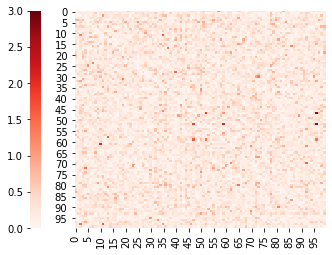

In [9]:
# MLKD baseline
mpath = "/home/ssq/Desktop/phd/KD/Multi-Level-Logit-Distillation-main/output/cifar100_baselines/kd_ours,res32x4,res8x4/student_best"
diff = get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:10, 14.67it/s]
157it [00:53,  2.93it/s]


max(diff): 1.905908230729401 5572
mean(diff): 0.1841731368187575


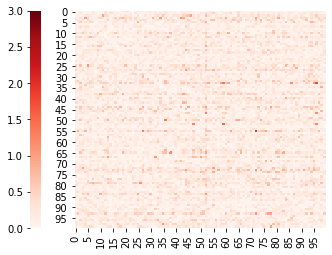

In [10]:
# MLKD baseline with ours
mpath = "/home/ssq/Desktop/phd/KD/Multi-Level-Logit-Distillation-main/output/cifar100_baselines/kd_ours,res32x4,res8x4_1/student_best"
diff = get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:11, 14.20it/s]
157it [00:50,  3.10it/s]


max(diff): 0.43814678800292306 4796
mean(diff): 0.05602374994858942


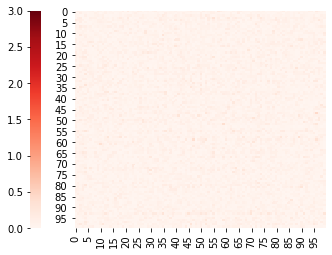

In [11]:
# MLKD baseline with ours if stand
mpath = "/home/ssq/Desktop/phd/KD/Multi-Level-Logit-Distillation-main/output/cifar100_baselines/kd_ours,res32x4,res8x4_1/student_best"
diff = get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF, ifstand=True)

In [ ]:
MAX_DIFF = 7.5

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:14, 11.04it/s]
157it [01:06,  2.37it/s]


max(diff): 3.02743573307991 5259
mean(diff): 0.26958020278826045


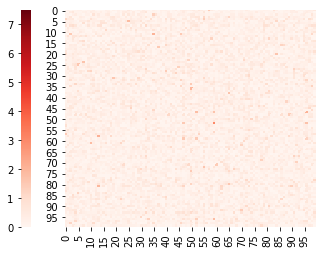

In [44]:
# KD baseline
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines_0/kd,res32x4,res8x4/student_best"
diff = get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:14, 11.12it/s]
157it [01:04,  2.42it/s]


max(diff): 7.3626576663181185 5247
mean(diff): 0.9393253251458072


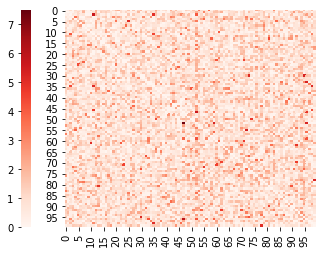

In [45]:
# KD baseline with ours (visual w/o standardization)
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/kd,res32x4,res8x4/student_best"
diff = get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:13, 11.54it/s]
157it [01:04,  2.45it/s]


max(diff): 1.1755519018508493 9765
mean(diff): 0.1887959677165773


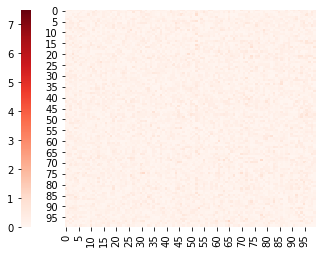

In [46]:
# KD baseline with ours
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/kd,res32x4,res8x4/student_best"
diff = get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF, ifstand=True)

In [314]:
MAX_DIFF = 4.5

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:14, 11.06it/s]
157it [01:05,  2.38it/s]


max(diff): 0.9871031072735788 4796
mean(diff): 0.13006522007298468


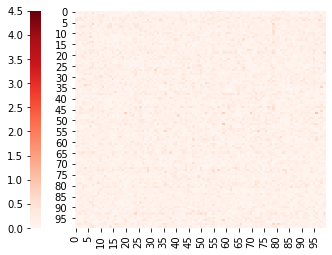

array([[0.        , 0.0465766 , 0.03831374, ..., 0.1103127 , 0.08134926,
        0.00110874],
       [0.02899796, 0.        , 0.19158003, ..., 0.12816903, 0.03759476,
        0.2609489 ],
       [0.04332454, 0.05271297, 0.        , ..., 0.17837451, 0.26635067,
        0.02919705],
       ...,
       [0.04111731, 0.07117529, 0.01528786, ..., 0.        , 0.22942288,
        0.02070178],
       [0.14286085, 0.31851749, 0.27861183, ..., 0.13800784, 0.        ,
        0.23358566],
       [0.03498501, 0.09019589, 0.09180478, ..., 0.10643304, 0.19285865,
        0.        ]])

In [315]:
# DKD
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines_0/dkd,res32x4,res8x4/student_best"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:13, 11.47it/s]
157it [01:01,  2.54it/s]


max(diff): 4.34629840195179 5247
mean(diff): 0.5380666481766856


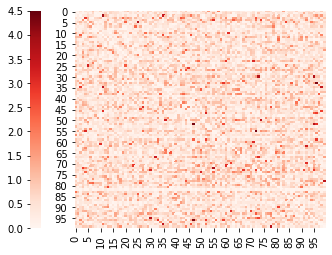

array([[0.        , 0.05918997, 0.51939046, ..., 0.28101032, 0.82885804,
        0.08344289],
       [0.13029653, 0.        , 0.17826592, ..., 0.25697126, 0.11704065,
        0.28301679],
       [0.04882439, 0.2446812 , 0.        , ..., 0.89449654, 1.59469782,
        0.55125426],
       ...,
       [0.73358272, 0.45447011, 0.54450753, ..., 0.        , 0.08515102,
        0.31230947],
       [0.84709001, 0.16736417, 1.19261743, ..., 0.02785366, 0.        ,
        0.0721181 ],
       [0.34889046, 0.50244691, 0.49429406, ..., 0.56487042, 0.10690558,
        0.        ]])

In [316]:
# DKD with ours (visual w/o standardization)
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/dkd,res32x4,res8x4/student_best"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:14, 11.09it/s]
157it [01:05,  2.40it/s]


max(diff): 3.611890917029232 3552
mean(diff): 0.07542268224508328


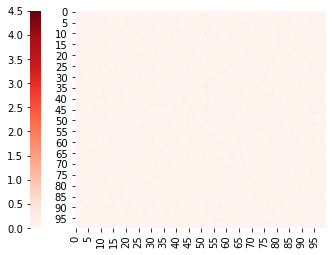

In [312]:
# DKD with ours (52, 95)
MAX_DIFF = 4.5
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/dkd,res32x4,res8x4/student_best"
diff = get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF, ifstand=True)


In [310]:
diff[diff>0.1] /= 10

array([0.03467297, 0.03362221, 0.03967996, 0.0367205 , 0.03665468,
       0.03466233, 0.0341727 , 0.0422448 , 0.03712477, 0.03548709,
       0.03758403, 0.03810735, 0.04179069, 0.03503867, 0.03563462,
       0.03686826, 0.03998061, 0.03734148, 0.03449236, 0.03195502,
       0.03681863, 0.03114324, 0.0310248 , 0.03795422, 0.03696813,
       0.03696238, 0.03505706, 0.03955619, 0.03477238, 0.03341818,
       0.03507588, 0.03839519, 0.03372097, 0.03974778, 0.03323691,
       0.03720804, 0.03371942, 0.04036906, 0.03740155, 0.03262982,
       0.04072695, 0.0380298 , 0.03514286, 0.03273518, 0.03447519,
       0.04040762, 0.03215375, 0.03360987, 0.03540401, 0.03265974,
       0.04036346, 0.03719508, 0.03363608, 0.03547672, 0.03420873,
       0.03631705, 0.03545707, 0.04114971, 0.03351425, 0.03297495,
       0.03866983, 0.03619259, 0.03612204, 0.04116905, 0.03438159,
       0.03344388, 0.03790212, 0.03728103, 0.03789548, 0.03361494,
       0.0353331 , 0.03083296, 0.03467805, 0.03851093, 0.03924

In [320]:
MAX_DIFF = 7.5

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:14, 10.91it/s]
157it [01:05,  2.41it/s]


max(diff): 3.185578840076923 5247
mean(diff): 0.36534868103436957


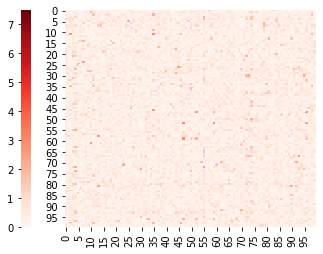

array([[0.        , 0.14328328, 0.23543491, ..., 0.7258995 , 0.26193003,
        0.36844798],
       [0.09867103, 0.        , 0.05351303, ..., 0.15895581, 0.69238611,
        0.19892865],
       [0.52184405, 0.27942917, 0.        , ..., 0.04550158, 1.6667211 ,
        0.1030363 ],
       ...,
       [0.02569977, 0.02080349, 0.00835392, ..., 0.        , 0.11874593,
        0.55446191],
       [0.16326214, 0.49496084, 1.32311261, ..., 0.10077028, 0.        ,
        0.45591369],
       [0.5974745 , 0.22756209, 0.14556853, ..., 0.48719505, 0.00876611,
        0.        ]])

In [321]:
# CTKD
mpath = "/home/ssq/Desktop/phd/KD/CTKD-main/save/student_model0/tea-res32x4-stu-res8x4/kd/fold-1/resnet8x4_best.pth"
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:14, 11.03it/s]
157it [01:04,  2.45it/s]


max(diff): 7.3923410035669805 5247
mean(diff): 0.9421487486693996


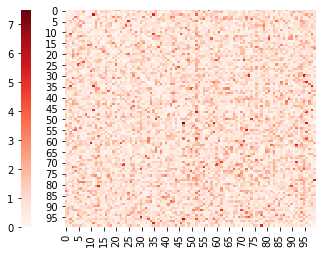

array([[0.        , 0.2532877 , 0.98782274, ..., 0.68065838, 1.76918873,
        0.42615038],
       [0.07230222, 0.        , 0.17214428, ..., 0.90252698, 0.39292359,
        0.74704548],
       [0.15285855, 0.29862403, 0.        , ..., 1.15506192, 2.29229988,
        0.8322556 ],
       ...,
       [1.34002487, 1.13497759, 1.24888115, ..., 0.        , 0.10592283,
        0.48118637],
       [1.23820868, 0.31191411, 1.85262719, ..., 0.16377263, 0.        ,
        0.11469978],
       [0.38257997, 0.72633516, 0.63884789, ..., 0.83770114, 0.20285353,
        0.        ]])

In [322]:
# CTKD with ours (visual w/o standardization)
mpath = '/home/ssq/Desktop/phd/KD/CTKD-main/save/student_model/tea-res32x4-stu-res8x4/kd_ours/fold-1/resnet8x4_best.pth'
get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:14, 10.96it/s]
157it [01:06,  2.37it/s]


max(diff): 0.5982324654236435 246
mean(diff): 0.08591410004265099


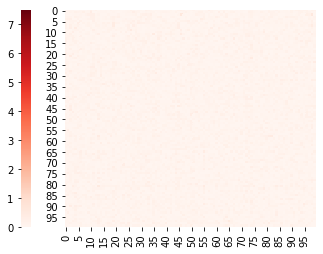

In [323]:
# CTKD with ours
mpath = '/home/ssq/Desktop/phd/KD/CTKD-main/save/student_model/tea-res32x4-stu-res8x4/kd_ours/fold-1/resnet8x4_best.pth'
diff = get_tea_stu_diff("resnet32x4", "resnet8x4", mpath, MAX_DIFF, ifstand=True)


In [27]:
diff[:,52]

array([1.92931003e-02, 8.56131552e-02, 1.02014220e+00, 1.45846911e-01,
       1.68863361e-01, 5.19310016e-01, 9.14540338e-02, 1.34443778e-01,
       1.43054781e-01, 2.24191148e-01, 5.39816545e-01, 1.14303782e+00,
       1.31895597e-01, 1.07171619e-01, 2.11864542e-01, 9.82814583e-02,
       4.95877647e-01, 7.61358842e-04, 2.36022358e-01, 1.44066245e-01,
       2.10181164e-01, 9.20216480e-02, 3.15556780e-01, 1.76826758e-02,
       1.76680455e-01, 5.04561134e-01, 2.01743887e-01, 2.47779928e-01,
       3.89204890e-01, 1.56215024e-01, 2.03992082e-01, 8.81953159e-02,
       3.56198154e-01, 2.96496110e-02, 1.45897542e-01, 1.20396364e+00,
       3.81883008e-01, 1.03065804e-01, 1.77027813e-01, 1.98670817e-01,
       4.99123601e-01, 5.97163503e-02, 4.28507514e-02, 2.23855775e-02,
       3.78276132e-01, 3.02996483e-01, 1.03711241e+00, 8.49799266e-02,
       2.92662265e-02, 2.80782639e-02, 3.82609101e-01, 3.03683049e-01,
       0.00000000e+00, 1.54316772e-02, 1.63826552e-01, 3.14768256e-01,
      

In [5]:
# visualize the difference between the teacher's output logits and the student's
def normalize(logit):
    mean = logit.mean(dim=-1, keepdims=True)
    stdv = logit.std(dim=-1, keepdims=True)
    return (logit - mean) / stdv

def get_output_metric_oneindex(model, val_loader, num_classes=100, ifstand=False):
    model.eval()
    index = 7#7, 12
    all_preds, all_labels = None, None
    sample = None
    label = None
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            if i != index:
                continue
            sample = data[0]
            label = labels[0]
#             plt.imshow(sample.permute(1,2,0))
            outputs, _ = model(data)
            if ifstand:
                preds = normalize(outputs)
            else:
                preds = outputs
            all_preds = preds.data.cpu().numpy()
            all_labels = labels.data.cpu().numpy()
    print(all_preds.shape, label)
    print(all_preds.mean(-1).max(), all_preds.std(-1).max())
    return all_preds[0], all_preds.std(-1).max()

def get_tea_stu_diff_oneindex(tea, stu, mpath, ifstand=False):
    cfg.defrost()
    cfg.DISTILLER.STUDENT = stu
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    model = cifar_model_dict[cfg.DISTILLER.STUDENT][0](num_classes=num_classes)
    model.load_state_dict(load_checkpoint(mpath)["model"])
    tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
    tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    print("load model successfully!")
    ms, maxstd_s = get_output_metric_oneindex(model, val_loader, ifstand=ifstand)
    mt, maxstd_t = get_output_metric_oneindex(tea_model, val_loader, ifstand=ifstand)
    font_size=18
    x = list(range(100)) #["1"]*100
    xlabels = []
    for ii in range(10):
        xlabels += [ii*10]
        xlabels += [''] * 9
    plt.figure(figsize=(9,5))
    ax = seaborn.barplot(x=np.array(x), y=mt, color='blue' )
    ax = seaborn.barplot(x=np.array(x), y=ms, color='red')
    ax.tick_params(bottom=False,top=False,left=False,right=False)
    ax.set_xticklabels(xlabels, fontsize=17)
    topbar = plt.Rectangle((0,0),1,1,fc="red", edgecolor = 'none')
    bottombar = plt.Rectangle((0,0),1,1,fc='blue',  edgecolor = 'none')
    l = plt.legend([bottombar, topbar], ['teacher, std.=%.2f'%(maxstd_t), 'student, std.=%.2f'%(maxstd_s)], loc=1, ncol = 1, prop={'size':font_size})
    l.draw_frame(False)
    plt.yticks(fontsize=17)
    plt.ylim(-5,12.5)
    plt.tight_layout()
    plt.xlabel("class category", fontsize = font_size)
    plt.ylabel("logit value", fontsize = font_size)
    plt.show()
    plt.close()
    
#     plt.figure(figsize=(7,5))
#     ax.set_xticklabels(xlabels, fontsize=17)
#     plt.yticks(fontsize=17)
#     plt.xlabel("class", fontsize = 20)
#     plt.ylabel("logit", fontsize = 20)
#     plt.show()
    print(ms.mean(), mt.mean())
    return ms, mt

Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:03, 51.59it/s]


(64, 100) tensor(55)
1.8617548e-05 3.7843559


157it [00:03, 48.17it/s]


(64, 100) tensor(55)
1.0374784e-05 3.095494


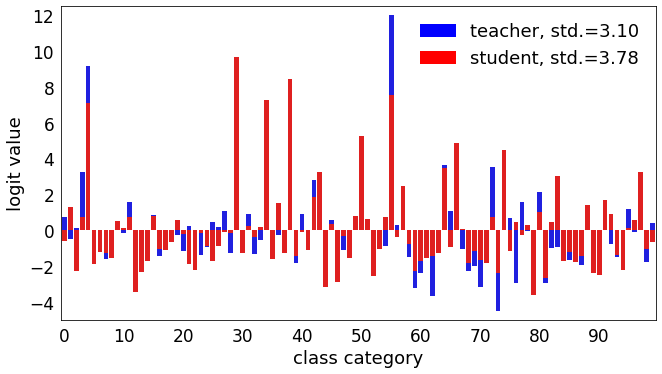

1.150012e-05 7.148385e-06


In [6]:
# KD 
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines_0/kd,res32x4,res8x4/student_best"
ms, mt = get_tea_stu_diff_oneindex("resnet32x4", "resnet8x4", mpath, )


Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:03, 52.26it/s]

(64, 100) tensor(55)
1.9967556e-08 0.9949875



157it [00:03, 43.71it/s]


(64, 100) tensor(55)
2.4884939e-08 0.99498755


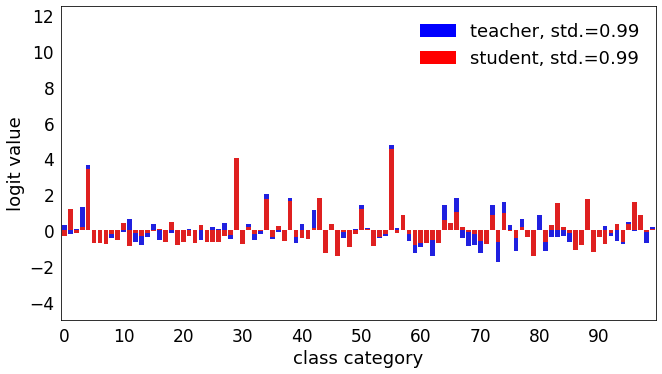

7.860362e-09 2.3841857e-09


In [7]:
# KD with ours
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/kd,res32x4,res8x4/student_best"
ms, mt = get_tea_stu_diff_oneindex("resnet32x4", "resnet8x4", mpath, ifstand=True)


Files already downloaded and verified
Files already downloaded and verified
load model successfully!


157it [00:02, 54.60it/s]

(64, 100) tensor(55)
3.873557e-07 0.47601748



157it [00:03, 43.40it/s]


(64, 100) tensor(55)
1.0374784e-05 3.095494


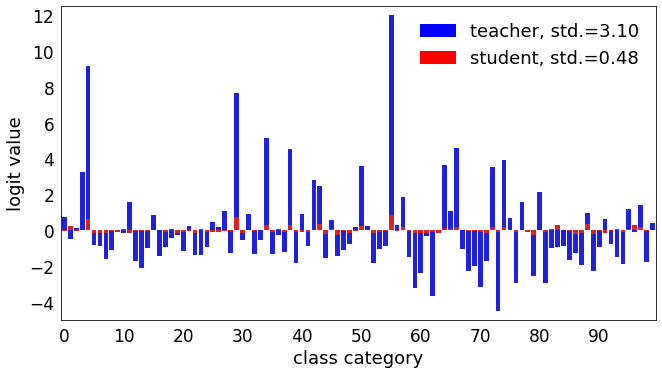

1.9522383e-07 7.148385e-06


In [8]:
# KD with ours (w/o standardization)
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/kd,res32x4,res8x4/student_best"
ms, mt = get_tea_stu_diff_oneindex("resnet32x4", "resnet8x4", mpath)


In [13]:
# visualize the difference between the teacher's output logits and the student's
def normalize(logit):
    mean = logit.mean(dim=-1, keepdims=True)
    stdv = logit.std(dim=-1, keepdims=True)
    return (logit - mean) / stdv
import numpy as np
def get_output_metric(model, val_loader, num_classes=100, ifstand=False):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for i, (data, labels) in tqdm(enumerate(val_loader)):
            outputs, _ = model(data)
            if ifstand:
                preds = normalize(outputs)
            else:
                preds = outputs
            all_preds.append(preds.data.cpu().numpy())
            all_labels.append(labels.data.cpu().numpy())
    
    all_preds = np.concatenate(all_preds, 0)
    all_labels = np.concatenate(all_labels, 0)
    matrix = np.zeros((num_classes, num_classes))
    cnt = np.zeros((num_classes, 1))
    mean = []
    stdv = []
    for p, l in zip(all_preds, all_labels):
        mean.append(p.mean())
        stdv.append(p.std())
    print(np.mean(mean), np.mean(stdv))
    return mean, stdv
from torchsummary import summary

def get_tea_logit(tea, max_diff, ifstand=False, mpath=None):
    cfg.defrost()
    cfg.DISTILLER.TEACHER = tea
    cfg.DATASET.TYPE = 'cifar100'
    cfg.freeze()
    train_loader, val_loader, num_data, num_classes = get_dataset(cfg)
    if mpath is None:
        tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
        tea_model.load_state_dict(load_checkpoint(cifar_model_dict[cfg.DISTILLER.TEACHER][1])["model"])
    else:
        tea_model = cifar_model_dict[cfg.DISTILLER.TEACHER][0](num_classes=num_classes)
        tea_model.load_state_dict(load_checkpoint(mpath)["model"])
    
    print("load model successfully!")
    summary(tea_model, input_size=(3, 32, 32), device="cpu")
    mt = get_output_metric(tea_model, val_loader, ifstand=ifstand)
    return mt

In [325]:
MAX_DIFF = 15

In [22]:
mt1 = get_tea_logit("resnet56", MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
        BasicBlock-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
             ReLU-12           [-1, 16, 32, 32]               0
  

157it [00:09, 16.34it/s]


-9.605546e-06 3.8227746


In [54]:
mt2 = get_tea_logit("resnet110", MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
        BasicBlock-9           [-1, 16, 32, 32]               0
           Conv2d-10           [-1, 16, 32, 32]           2,304
      BatchNorm2d-11           [-1, 16, 32, 32]              32
             ReLU-12           [-1, 16, 32, 32]               0
  

157it [00:28,  5.43it/s]


-2.7120299e-05 3.8804


In [55]:
mt3 = get_tea_logit("wrn_40_2", MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 32, 32]           4,608
       BatchNorm2d-5           [-1, 32, 32, 32]              64
              ReLU-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
            Conv2d-8           [-1, 32, 32, 32]             512
        BasicBlock-9           [-1, 32, 32, 32]               0
      BatchNorm2d-10           [-1, 32, 32, 32]              64
             ReLU-11           [-1, 32, 32, 32]               0
           Conv2d-12           [-1, 32, 32, 32]           9,216
  

157it [00:26,  5.88it/s]


-9.4645384e-07 2.8966782


In [20]:
mt4 = get_tea_logit("resnet32x4", MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
  

157it [00:53,  2.93it/s]


5.589208e-06 2.1117096


In [57]:
mt5 = get_tea_logit("vgg13", MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
         MaxPool2d-6           [-1, 64, 16, 16]               0
            Conv2d-7          [-1, 128, 16, 16]          73,856
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]         147,584
      BatchNorm2d-11          [-1, 128, 16, 16]             256
        MaxPool2d-12            [-1, 128, 8, 8]               0
  

157it [00:19,  7.91it/s]


-5.410505e-06 2.1321638


In [133]:
mt6 = get_tea_logit("ResNet50", MAX_DIFF)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]           4,096
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 256, 32, 32]          16,384
       BatchNorm2d-8          [-1, 256, 32, 32]             512
            Conv2d-9          [-1, 256, 32, 32]          16,384
      BatchNorm2d-10          [-1, 256, 32, 32]             512
       Bottleneck-11          [-1, 256, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          16,384
  

157it [03:11,  1.22s/it]


1.1651749e-06 2.5815306


In [132]:
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines_0/kd,res32x4,res8x4/student_best"

mt7 = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:14, 10.58it/s]


1.1666388e-05 2.4193327


In [138]:
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/kd,res32x4,res8x4/student_best"

mt8 = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:14, 10.48it/s]


1.752744e-07 0.23675068


In [18]:
mt9 = get_tea_logit("resnet32x4", MAX_DIFF, ifstand=True)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
  

157it [00:51,  3.07it/s]


1.6125825e-11 0.9949875


In [153]:
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/kd,res32x4,res8x4/student_best"

mt10 = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath,ifstand=True)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:14, 10.79it/s]


-9.8387326e-11 0.9949875


In [282]:
import pandas as pd
model_names = ["resnet56", 'resnet110', 'wrn_40_2', 'resnet32x4', 'vgg13', 'resnet50', ]
model_sizes = ["861,620", '1,736,564', '2,255,604', '7,433,860', '9,462,180', '23,705,252']
num_blanks = [4,2,3,0,8,3]
means = mt1[0] + mt2[0] + mt3[0] + mt4[0] + mt5[0] + mt6[0]
stdvs = mt1[1] + mt2[1] + mt3[1] + mt4[1] + mt5[1] + mt6[1]
num_data = len(mt1[0])
model_col = []
for ii, (i, j) in enumerate(zip(model_names, model_sizes)):
    model_col += [i + ', ' + ' '*num_blanks[ii] + 'size: ' + j] * num_data
data = {"mean": means, 'stdv': stdvs, 'model': model_col}
data = pd.DataFrame(data=data)

In [283]:
colors = ['blue', 'orange', 'green', 'red', 'purple']

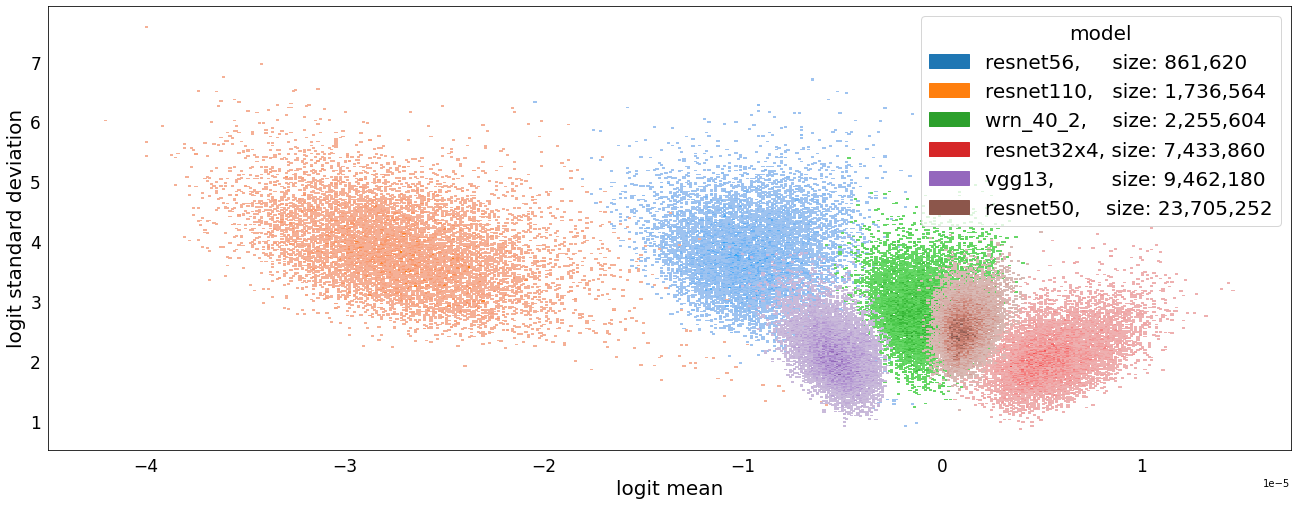

In [284]:
plt.figure(figsize=(18,7))
font_size = 20
ax = seaborn.histplot(data, x="mean", y="stdv", hue="model", cbar=False, cbar_kws=dict(shrink=.75), bins=500, color=colors)
ax.tick_params(bottom=False,top=False,left=False,right=False)
# ax.set_xticklabels(xlabels, fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
# plt.ylim(-5,12.5)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 
 
    
plt.tight_layout()
plt.xlabel("logit mean", fontsize = font_size)
plt.ylabel("logit standard deviation", fontsize = font_size)
plt.show()
    

In [285]:
import pandas as pd
model_names = ['teacher_standardized', 'student_Ours_standardized', ] + ['teacher', 'student_KD', 'student_Ours']
model_sizes = ['7,433,860', '1,233,540'] + ['7,433,860', '1,233,540', '1,233,540']
num_blanks = [9,0] + [31,25,22]
means = mt9[0] + mt10[0] + mt4[0] + mt7[0] + mt8[0]
stdvs = mt9[1] + mt10[1] + mt4[1] + mt7[1] + mt8[1]
num_data = len(mt1[0])
model_col = []
for ii, (i, j) in enumerate(zip(model_names, model_sizes)):
    model_col += [i] * num_data
#     model_col += [i + ', ' + ' '*num_blanks[ii] + 'size: ' + j] * num_data
data = {"mean": means, 'stdv': stdvs, 'model': model_col}
data = pd.DataFrame(data=data)

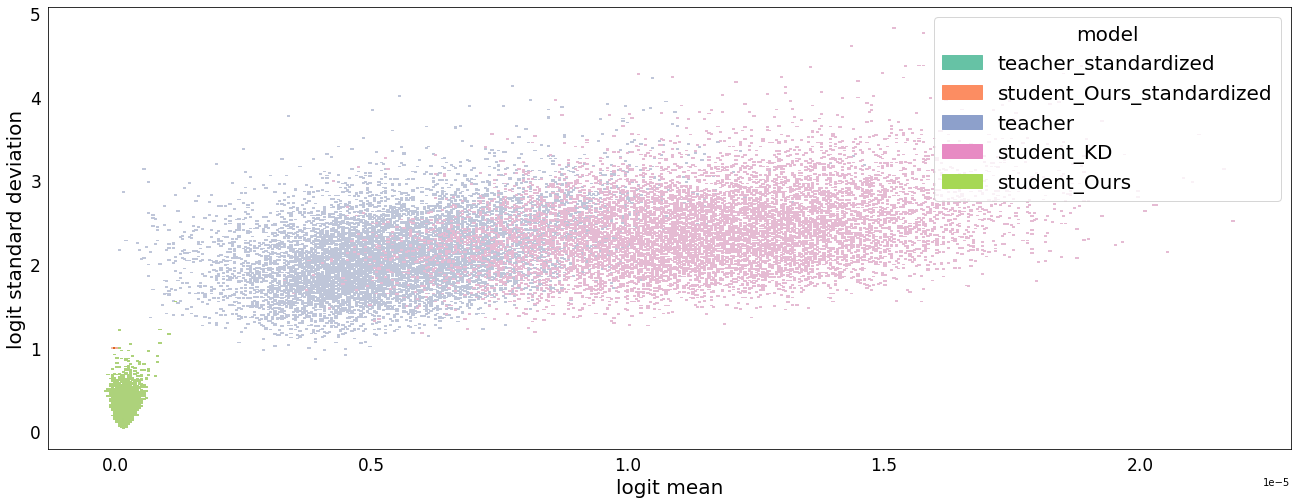

In [286]:
plt.figure(figsize=(18,7))
font_size = 20
ax = seaborn.histplot(data, x="mean", y="stdv", hue="model", cbar=False, cbar_kws=dict(shrink=.75), bins=500, palette='Set2')
ax.tick_params(bottom=False,top=False,left=False,right=False)
# ax.set_xticklabels(xlabels, fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
# plt.ylim(-5,12.5)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# axins = inset_axes(ax, width="40%", height="30%", loc='lower right',
#                    bbox_to_anchor=(0.3, 0.0, 0.7, 1), 
#                    bbox_transform=ax.transAxes)
# axins.histplot
plt.tight_layout()
plt.xlabel("logit mean", fontsize = font_size)
plt.ylabel("logit standard deviation", fontsize = font_size)
plt.show()
    

In [267]:
import pandas as pd
model_names = ['tea_resnet32x4_st'] + ['stu_resnet8x4_Ours_st']
model_sizes = ['7,433,860'] + ['1,233,540']
num_blanks = [0] + [0]
means = mt9[0] + mt10[0]
stdvs = mt9[1] + mt10[1]
num_data = len(mt1[0])
model_col = []
for ii, (i, j) in enumerate(zip(model_names, model_sizes)):
    model_col += [i + ', ' + ' '*num_blanks[ii] + 'size: ' + j] * num_data
data = {"mean": means, 'stdv': stdvs, 'model': model_col}
data = pd.DataFrame(data=data)

No handles with labels found to put in legend.


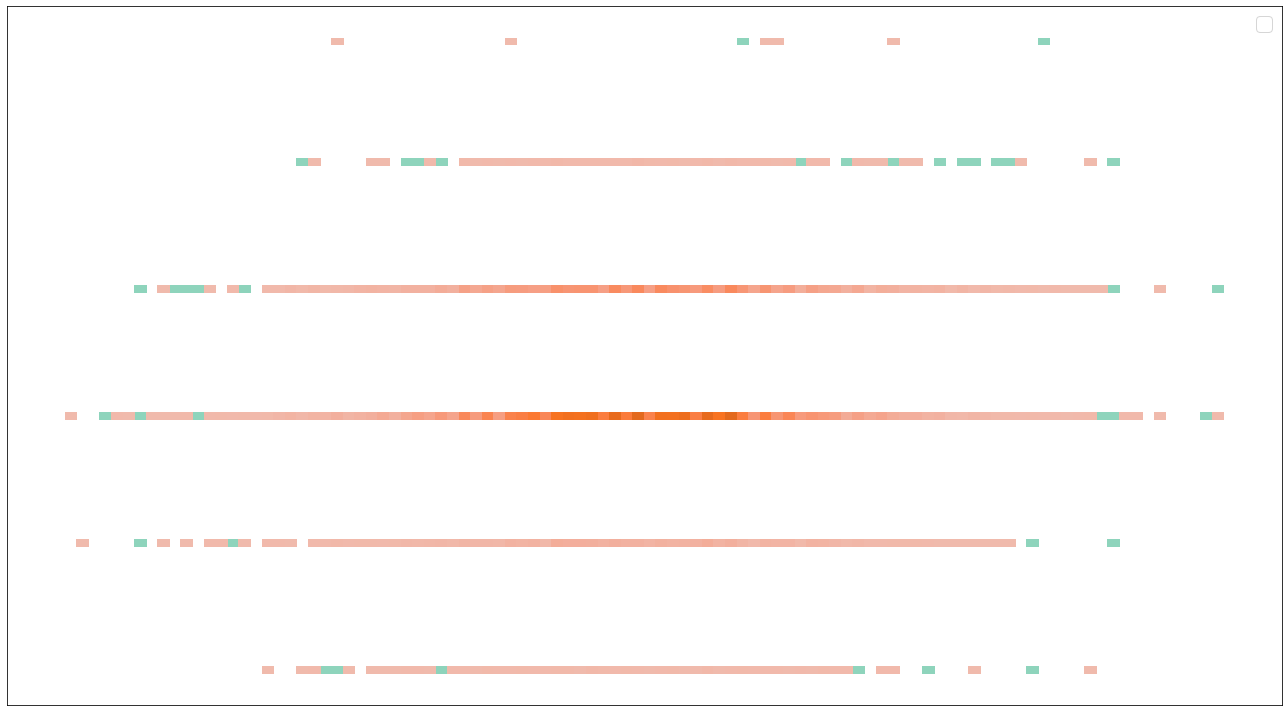

In [268]:
plt.figure(figsize=(18,10))
font_size = 20
ax = seaborn.histplot(data, x="mean", y="stdv", hue="model", cbar=False, cbar_kws=dict(shrink=.75), bins=100, 
                      palette='Set2', )
ax.tick_params(bottom=False,top=False,left=False,right=False)
# ax.set_xticklabels(xlabels, fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
# plt.ylim(-5,12.5)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# axins = inset_axes(ax, width="40%", height="30%", loc='lower right',
#                    bbox_to_anchor=(0.3, 0.0, 0.7, 1), 
#                    bbox_transform=ax.transAxes)
# axins.histplot
# plt.xlim(-1e-6,1e-6)
# plt.ylim(-1,2)
plt.legend()
plt.yticks([])
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()
    

In [213]:
colors

['blue', 'orange', 'green', 'red', 'purple']

In [348]:
mpath = "/home/ssq/Desktop/phd/KD/CTKD-main/save/student_model0/tea-res32x4-stu-res8x4/kd/fold-1/resnet8x4_best.pth"

mt7_ = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:14, 10.93it/s]


1.5456302e-05 2.6660707


In [349]:
mpath = "/home/ssq/Desktop/phd/KD/CTKD-main/save/student_model/tea-res32x4-stu-res8x4/kd_ours/fold-1/resnet8x4_best.pth"

mt8_ = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:14, 10.96it/s]


1.7846516e-07 0.1810532


In [350]:
mpath = "/home/ssq/Desktop/phd/KD/CTKD-main/save/student_model/tea-res32x4-stu-res8x4/kd_ours/fold-1/resnet8x4_best.pth"

mt10_ = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath,ifstand=True)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:14, 10.94it/s]


4.2278313e-11 0.9949875


In [351]:
import pandas as pd
model_names = ['teacher_standardized', 'student_Ours_standardized', ] + ['teacher', 'student_KD', 'student_Ours']
model_sizes = ['7,433,860', '1,233,540'] + ['7,433,860', '1,233,540', '1,233,540']
num_blanks = [9,0] + [31,25,22]
means = mt9[0] + mt10_[0] + mt4[0] + mt7_[0] + mt8_[0]
stdvs = mt9[1] + mt10_[1] + mt4[1] + mt7_[1] + mt8_[1]
num_data = len(mt1[0])
model_col = []
for ii, (i, j) in enumerate(zip(model_names, model_sizes)):
    model_col += [i] * num_data
#     model_col += [i + ', ' + ' '*num_blanks[ii] + 'size: ' + j] * num_data
data = {"mean": means, 'stdv': stdvs, 'model': model_col}
data = pd.DataFrame(data=data)

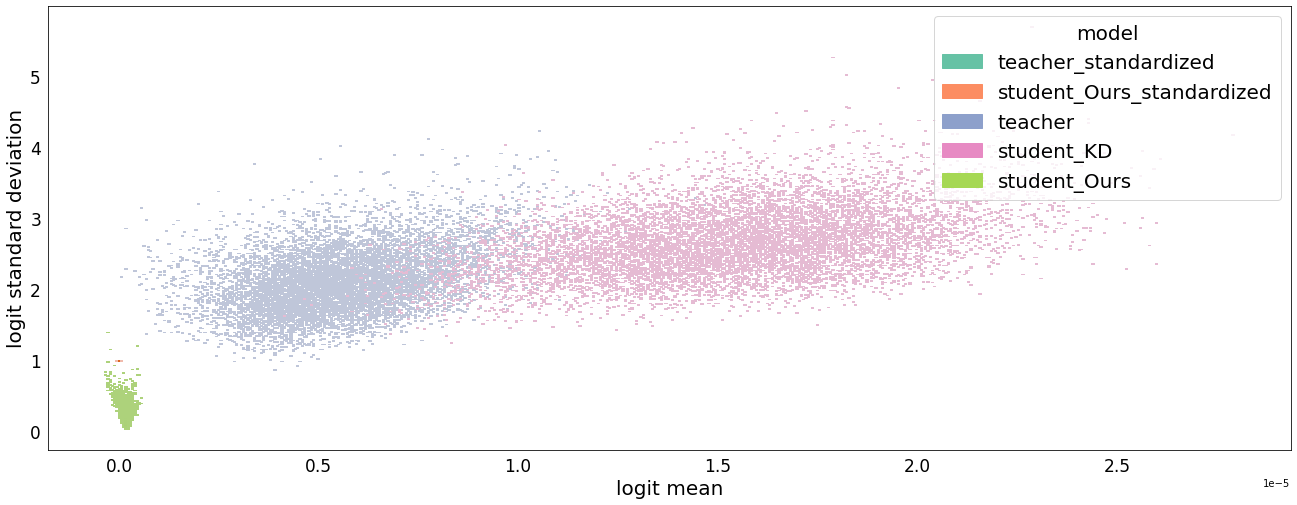

In [352]:
plt.figure(figsize=(18,7))
font_size = 20
ax = seaborn.histplot(data, x="mean", y="stdv", hue="model", cbar=False, cbar_kws=dict(shrink=.75), bins=500, palette='Set2')
ax.tick_params(bottom=False,top=False,left=False,right=False)
# ax.set_xticklabels(xlabels, fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
# plt.ylim(-5,12.5)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# axins = inset_axes(ax, width="40%", height="30%", loc='lower right',
#                    bbox_to_anchor=(0.3, 0.0, 0.7, 1), 
#                    bbox_transform=ax.transAxes)
# axins.histplot
plt.tight_layout()
plt.xlabel("logit mean", fontsize = font_size)
plt.ylabel("logit standard deviation", fontsize = font_size)
plt.show()
    

In [353]:
import pandas as pd
model_names = ['tea_resnet32x4_st'] + ['stu_resnet8x4_Ours_st']
model_sizes = ['7,433,860'] + ['1,233,540']
num_blanks = [0] + [0]
means = mt9[0] + mt10_[0]
stdvs = mt9[1] + mt10_[1]
num_data = len(mt1[0])
model_col = []
for ii, (i, j) in enumerate(zip(model_names, model_sizes)):
    model_col += [i + ', ' + ' '*num_blanks[ii] + 'size: ' + j] * num_data
data = {"mean": means, 'stdv': stdvs, 'model': model_col}
data = pd.DataFrame(data=data)

No handles with labels found to put in legend.


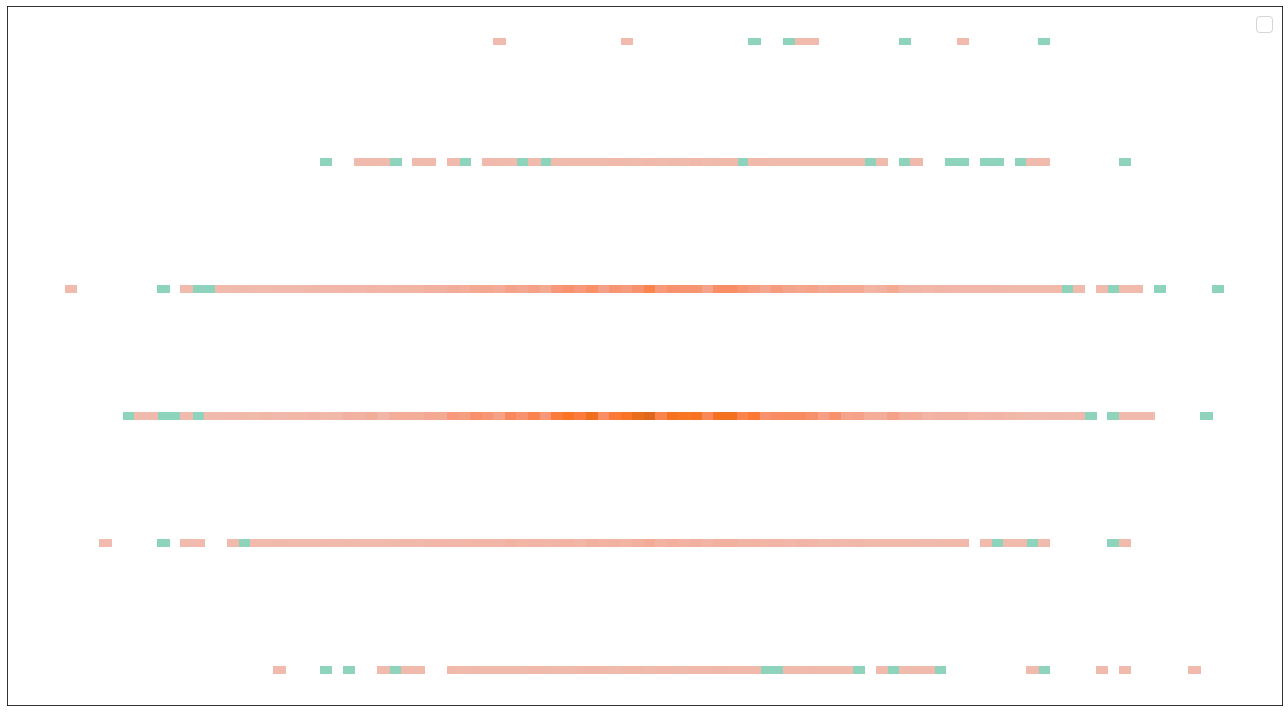

In [354]:
plt.figure(figsize=(18,10))
font_size = 20
ax = seaborn.histplot(data, x="mean", y="stdv", hue="model", cbar=False, cbar_kws=dict(shrink=.75), bins=100, 
                      palette='Set2', )
ax.tick_params(bottom=False,top=False,left=False,right=False)
# ax.set_xticklabels(xlabels, fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
# plt.ylim(-5,12.5)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# axins = inset_axes(ax, width="40%", height="30%", loc='lower right',
#                    bbox_to_anchor=(0.3, 0.0, 0.7, 1), 
#                    bbox_transform=ax.transAxes)
# axins.histplot
# plt.xlim(-1e-6,1e-6)
# plt.ylim(-1,2)
plt.legend()
plt.yticks([])
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()
    

In [340]:
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines_0/dkd,res32x4,res8x4/student_best"

mt7_ = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:14, 10.79it/s]


6.750994e-05 2.0362608


In [341]:
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/dkd,res32x4,res8x4/student_best"

mt8_ = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:14, 11.07it/s]


5.402933e-07 0.9748295


In [342]:
mpath = "/home/ssq/Desktop/phd/KD/mdistiller-master/output/cifar100_baselines/dkd,res32x4,res8x4/student_best"

mt10_ = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath,ifstand=True)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:14, 10.80it/s]


-1.4310636e-10 0.9949875


In [343]:
import pandas as pd
model_names = ['teacher_standardized', 'student_Ours_standardized', ] + ['teacher', 'student_KD', 'student_Ours']
model_sizes = ['7,433,860', '1,233,540'] + ['7,433,860', '1,233,540', '1,233,540']
num_blanks = [9,0] + [31,25,22]
means = mt9[0] + mt10_[0] + mt4[0] + mt7_[0] + mt8_[0]
stdvs = mt9[1] + mt10_[1] + mt4[1] + mt7_[1] + mt8_[1]
num_data = len(mt1[0])
model_col = []
for ii, (i, j) in enumerate(zip(model_names, model_sizes)):
    model_col += [i] * num_data
#     model_col += [i + ', ' + ' '*num_blanks[ii] + 'size: ' + j] * num_data
data = {"mean": means, 'stdv': stdvs, 'model': model_col}
data = pd.DataFrame(data=data)

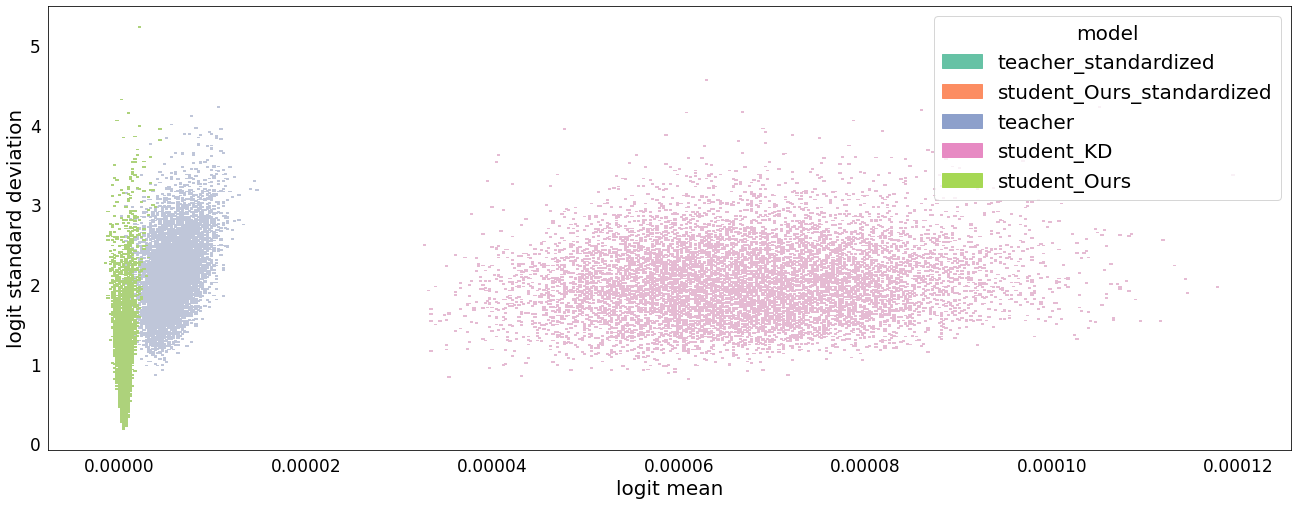

In [344]:
plt.figure(figsize=(18,7))
font_size = 20
ax = seaborn.histplot(data, x="mean", y="stdv", hue="model", cbar=False, cbar_kws=dict(shrink=.75), bins=500, palette='Set2')
ax.tick_params(bottom=False,top=False,left=False,right=False)
# ax.set_xticklabels(xlabels, fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
# plt.ylim(-5,12.5)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# axins = inset_axes(ax, width="40%", height="30%", loc='lower right',
#                    bbox_to_anchor=(0.3, 0.0, 0.7, 1), 
#                    bbox_transform=ax.transAxes)
# axins.histplot
plt.tight_layout()
plt.xlabel("logit mean", fontsize = font_size)
plt.ylabel("logit standard deviation", fontsize = font_size)
plt.show()
    

In [345]:
import pandas as pd
model_names = ['tea_resnet32x4_st'] + ['stu_resnet8x4_Ours_st']
model_sizes = ['7,433,860'] + ['1,233,540']
num_blanks = [0] + [0]
means = mt9[0] + mt10_[0]
stdvs = mt9[1] + mt10_[1]
num_data = len(mt1[0])
model_col = []
for ii, (i, j) in enumerate(zip(model_names, model_sizes)):
    model_col += [i + ', ' + ' '*num_blanks[ii] + 'size: ' + j] * num_data
data = {"mean": means, 'stdv': stdvs, 'model': model_col}
data = pd.DataFrame(data=data)

No handles with labels found to put in legend.


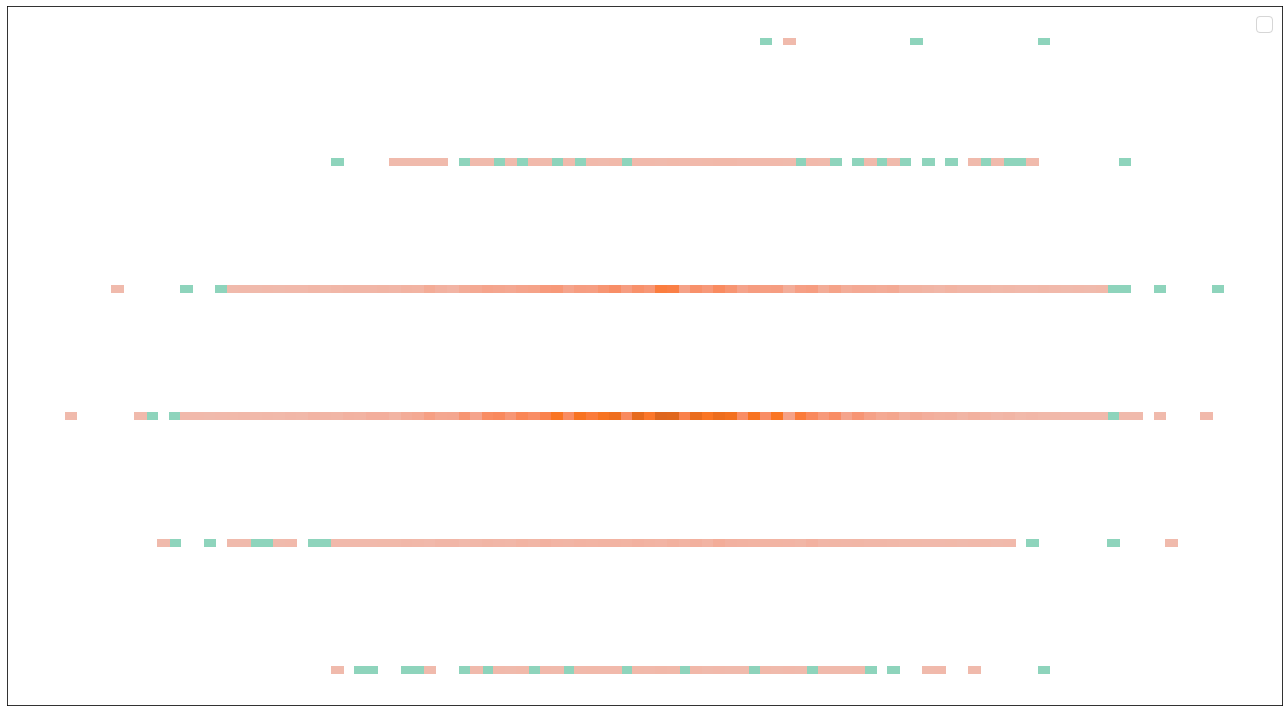

In [346]:
plt.figure(figsize=(18,10))
font_size = 20
ax = seaborn.histplot(data, x="mean", y="stdv", hue="model", cbar=False, cbar_kws=dict(shrink=.75), bins=100, 
                      palette='Set2', )
ax.tick_params(bottom=False,top=False,left=False,right=False)
# ax.set_xticklabels(xlabels, fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
# plt.ylim(-5,12.5)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# axins = inset_axes(ax, width="40%", height="30%", loc='lower right',
#                    bbox_to_anchor=(0.3, 0.0, 0.7, 1), 
#                    bbox_transform=ax.transAxes)
# axins.histplot
# plt.xlim(-1e-6,1e-6)
# plt.ylim(-1,2)
plt.legend()
plt.yticks([])
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()
    

In [14]:
# MLKD
mpath = "/home/ssq/Desktop/phd/KD/Multi-Level-Logit-Distillation-main/output/cifar100_baselines/kd_ours,res32x4,res8x4/student_best"

mt7_ = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:10, 14.78it/s]


2.6324456e-05 2.3247657


In [15]:
mpath = "/home/ssq/Desktop/phd/KD/Multi-Level-Logit-Distillation-main/output/cifar100_baselines/kd_ours,res32x4,res8x4_1/student_best"

mt8_ = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:10, 15.00it/s]


6.708826e-07 1.8250304


In [16]:
mpath = "/home/ssq/Desktop/phd/KD/Multi-Level-Logit-Distillation-main/output/cifar100_baselines/kd_ours,res32x4,res8x4_1/student_best"

mt10_ = get_tea_logit("resnet8x4", MAX_DIFF, mpath=mpath,ifstand=True)

Files already downloaded and verified
Files already downloaded and verified
load model successfully!
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          18,432
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           2,048
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11  [[-1, 64, 32, 32], [-1, 64, 32, 32]]               0
           Conv2d-12          [-1, 128, 16, 16]        

157it [00:10, 14.51it/s]


-1.1930686e-10 0.9949875


In [23]:
import pandas as pd
model_names = ['teacher_standardized', 'student_Ours_standardized', ] + ['teacher', 'student_KD', 'student_Ours']
model_sizes = ['7,433,860', '1,233,540'] + ['7,433,860', '1,233,540', '1,233,540']
num_blanks = [9,0] + [31,25,22]
means = mt9[0] + mt10_[0] + mt4[0] + mt7_[0] + mt8_[0]
stdvs = mt9[1] + mt10_[1] + mt4[1] + mt7_[1] + mt8_[1]
num_data = len(mt1[0])
model_col = []
for ii, (i, j) in enumerate(zip(model_names, model_sizes)):
    model_col += [i] * num_data
#     model_col += [i + ', ' + ' '*num_blanks[ii] + 'size: ' + j] * num_data
data = {"mean": means, 'stdv': stdvs, 'model': model_col}
data = pd.DataFrame(data=data)

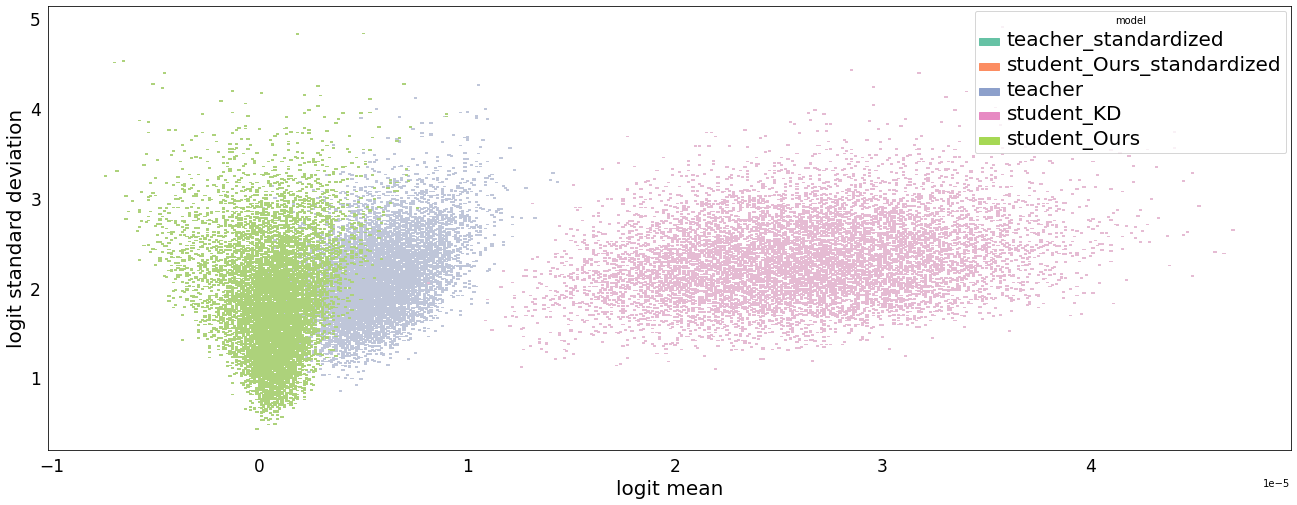

In [24]:
plt.figure(figsize=(18,7))
font_size = 20
ax = seaborn.histplot(data, x="mean", y="stdv", hue="model", cbar=False, cbar_kws=dict(shrink=.75), bins=500, palette='Set2')
ax.tick_params(bottom=False,top=False,left=False,right=False)
# ax.set_xticklabels(xlabels, fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
# plt.ylim(-5,12.5)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# axins = inset_axes(ax, width="40%", height="30%", loc='lower right',
#                    bbox_to_anchor=(0.3, 0.0, 0.7, 1), 
#                    bbox_transform=ax.transAxes)
# axins.histplot
plt.tight_layout()
plt.xlabel("logit mean", fontsize = font_size)
plt.ylabel("logit standard deviation", fontsize = font_size)
plt.show()
    

In [25]:
import pandas as pd
model_names = ['tea_resnet32x4_st'] + ['stu_resnet8x4_Ours_st']
model_sizes = ['7,433,860'] + ['1,233,540']
num_blanks = [0] + [0]
means = mt9[0] + mt10_[0]
stdvs = mt9[1] + mt10_[1]
num_data = len(mt1[0])
model_col = []
for ii, (i, j) in enumerate(zip(model_names, model_sizes)):
    model_col += [i + ', ' + ' '*num_blanks[ii] + 'size: ' + j] * num_data
data = {"mean": means, 'stdv': stdvs, 'model': model_col}
data = pd.DataFrame(data=data)

No handles with labels found to put in legend.


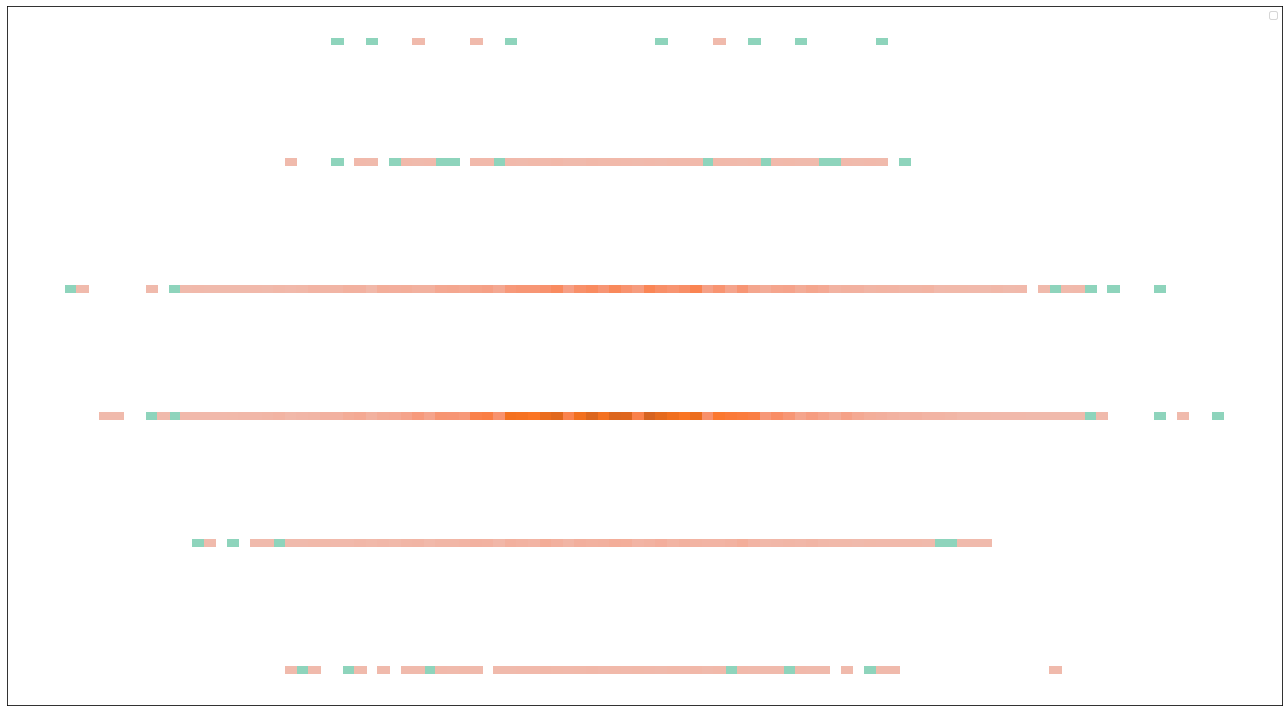

In [26]:
plt.figure(figsize=(18,10))
font_size = 20
ax = seaborn.histplot(data, x="mean", y="stdv", hue="model", cbar=False, cbar_kws=dict(shrink=.75), bins=100, 
                      palette='Set2', )
ax.tick_params(bottom=False,top=False,left=False,right=False)
# ax.set_xticklabels(xlabels, fontsize=17)
plt.yticks(fontsize=17)
plt.xticks(fontsize=17)
# plt.ylim(-5,12.5)
plt.setp(ax.get_legend().get_texts(), fontsize='20') 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# axins = inset_axes(ax, width="40%", height="30%", loc='lower right',
#                    bbox_to_anchor=(0.3, 0.0, 0.7, 1), 
#                    bbox_transform=ax.transAxes)
# axins.histplot
# plt.xlim(-1e-6,1e-6)
# plt.ylim(-1,2)
plt.legend()
plt.yticks([])
plt.xticks([])
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.show()
    